In [1]:
import os
import numpy as np
import cv2
from PIL import Image
from typing import Tuple

from shape import shape_mean, shape_modeling, normalise_shape

def get_coordinates(img_path, scale_x: int = 1, scale_y : int = 1):
    img_name = img_path.split('/')[-1].split('.')[0]
    coord_path = os.path.join(os.path.join(*img_path.split('/')[0:-1]), 'asf/{}.asf'.format(img_name))
    with open(coord_path) as f:
        content = f.readlines()
    lines = content[16: 89]
    points, from_ids, to_ids = [], [], []
    for info in lines:
        datas = info.split('\t')
        x = int(float(datas[2]) * scale_x)
        y = int(float(datas[3]) * scale_y)
        points.append((x, y))
        from_ids.append(int(datas[5]))
        to_ids.append(int(datas[6]))
    
    return points, from_ids, to_ids


In [2]:
datasets_home = './Active-Appearance-Models/data/imm3943/IMM-Frontal Face DB SMALL'
C = []

for image_file in os.listdir(datasets_home):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):           
        image_path = os.path.join(datasets_home, image_file)
        points, _, _ = get_coordinates(image_path, scale_x=800, scale_y=600)
        C.append(points)

C = np.array(C)
s_0, aligned_C, eig_values, eig_vecs = shape_modeling(C)

In [3]:
s_0.shape, aligned_C.shape, eig_values.shape, eig_vecs.shape

((146,), (120, 146), (146,), (146, 146))

In [4]:
# from shape_utils import compute_mean, compute_covariance_matrix
# z_mean, z = compute_mean(C)
# cov_matrix = compute_covariance_matrix(z, z_mean) # ndxnd matrix
# eig_values, eig_vecs = np.linalg.eig(cov_matrix)
# idx = eig_values.argsort()[::-1]
# eig_values = eig_values[idx]
# eig_vecs = eig_vecs[:,idx]

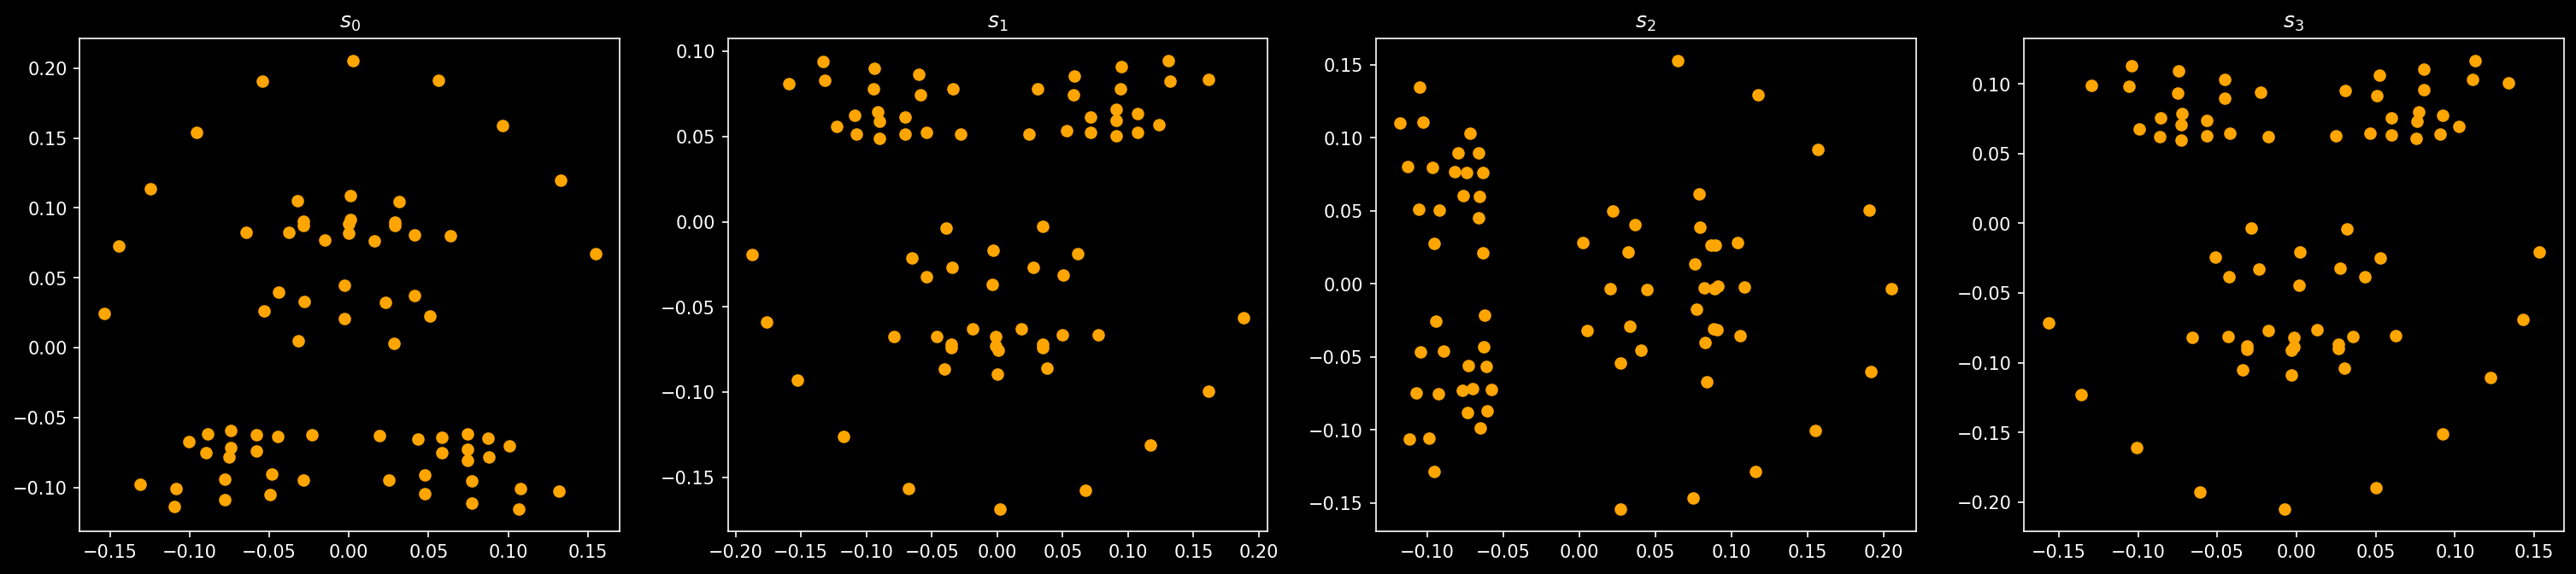

In [5]:
import matplotlib.pyplot as plt

def visualise_shape(s: np.ndarray, title: str):
    x_values = s[0: -2: 2]
    y_values = s[1: -1: 2]
    plt.scatter(x_values.real, y_values.real, marker='o', color='orange')
    plt.title(title)
    
plt.figure(dpi=150, figsize=[25, 5])
plt.subplot(1, 4, 1)
visualise_shape(s_0, '$s_0$')
plt.subplot(1, 4, 2)
visualise_shape(eig_vecs[:, 0], '$s_1$')
plt.subplot(1, 4, 3)
visualise_shape(eig_vecs[:, 1], '$s_2$')
plt.subplot(1, 4, 4)
visualise_shape(eig_vecs[:, 2], '$s_3$')

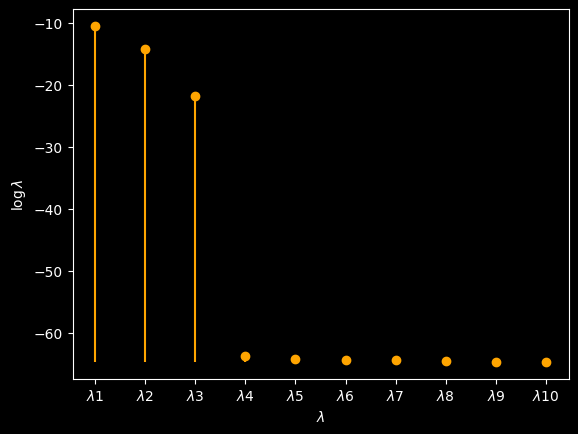

In [6]:
show_eig_values = np.log2(eig_values.real[:10])
plt.plot(np.log2(eig_values.real[:10]), 'o', color='orange')
plt.xticks(
    np.arange(len(show_eig_values)),
    [f'$\lambda{i + 1}$' for i in range(len(show_eig_values))]
)
plt.ylabel('$\log \lambda$')
plt.xlabel('$\lambda$')
plt.vlines(np.arange(len(show_eig_values)), ymin=np.ones(len(show_eig_values)) * min(show_eig_values), ymax=show_eig_values, colors='orange')

## Appearance

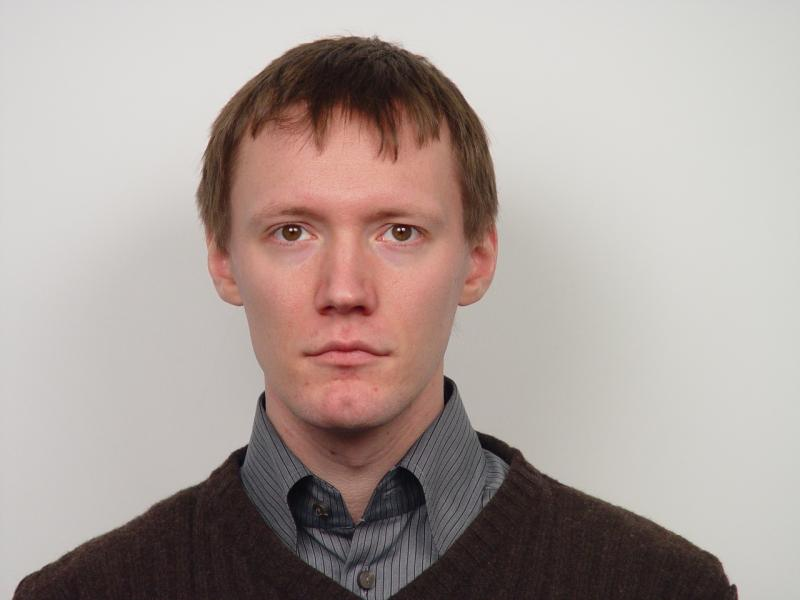

In [7]:
from appearance import normalise_appearance
import skimage.transform

test_image_path = os.path.join(datasets_home, '01_01.jpg')
test_image = cv2.imread(test_image_path)
Image.fromarray(test_image[..., ::-1])

In [8]:
from shape import denormalise_shape
points, _, _ = get_coordinates(test_image_path, scale_x=800, scale_y=600)
s = np.array([points])
real_s_0 = denormalise_shape(s_0.reshape(1, -1, 2), s)
source_control_points = real_s_0.reshape(-1, 2)
target_control_points = s.reshape(-1, 2)

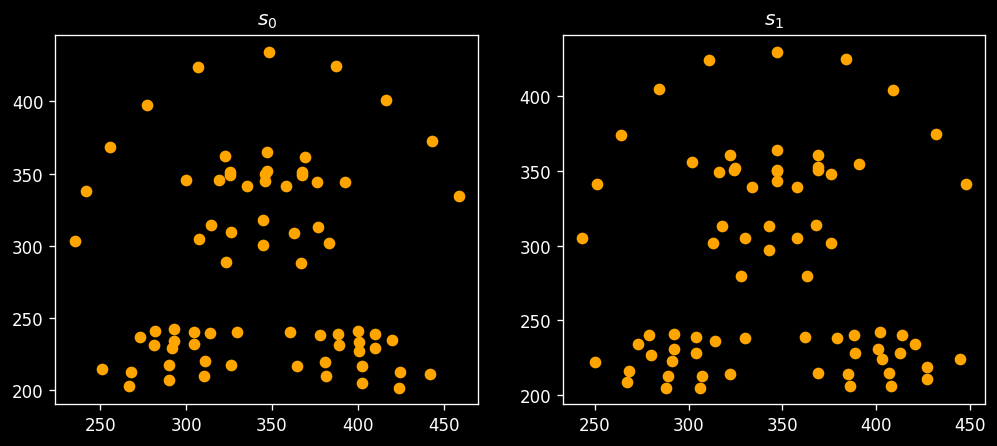

In [9]:
plt.figure(dpi=120, figsize=[10, 4])
plt.subplot(1, 2, 1)
visualise_shape(source_control_points.flatten(), '$s_0$')
plt.subplot(1, 2, 2)
visualise_shape(target_control_points.flatten(), '$s_1$')

In [10]:
h, w = test_image.shape[:2]
affine_trasnform = skimage.transform.PiecewiseAffineTransform()
affine_trasnform.estimate(src=source_control_points, dst=target_control_points)
warped_image = skimage.transform.warp(test_image, affine_trasnform)

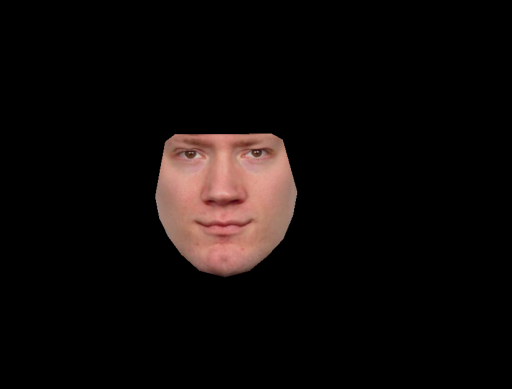

In [11]:
plt.axis('off')
plt.imshow(warped_image[..., ::-1])

In [12]:
import scipy.spatial
delaunay = scipy.spatial.Delaunay(points)
delaunay.simplices[0]

array([42, 63, 62], dtype=int32)

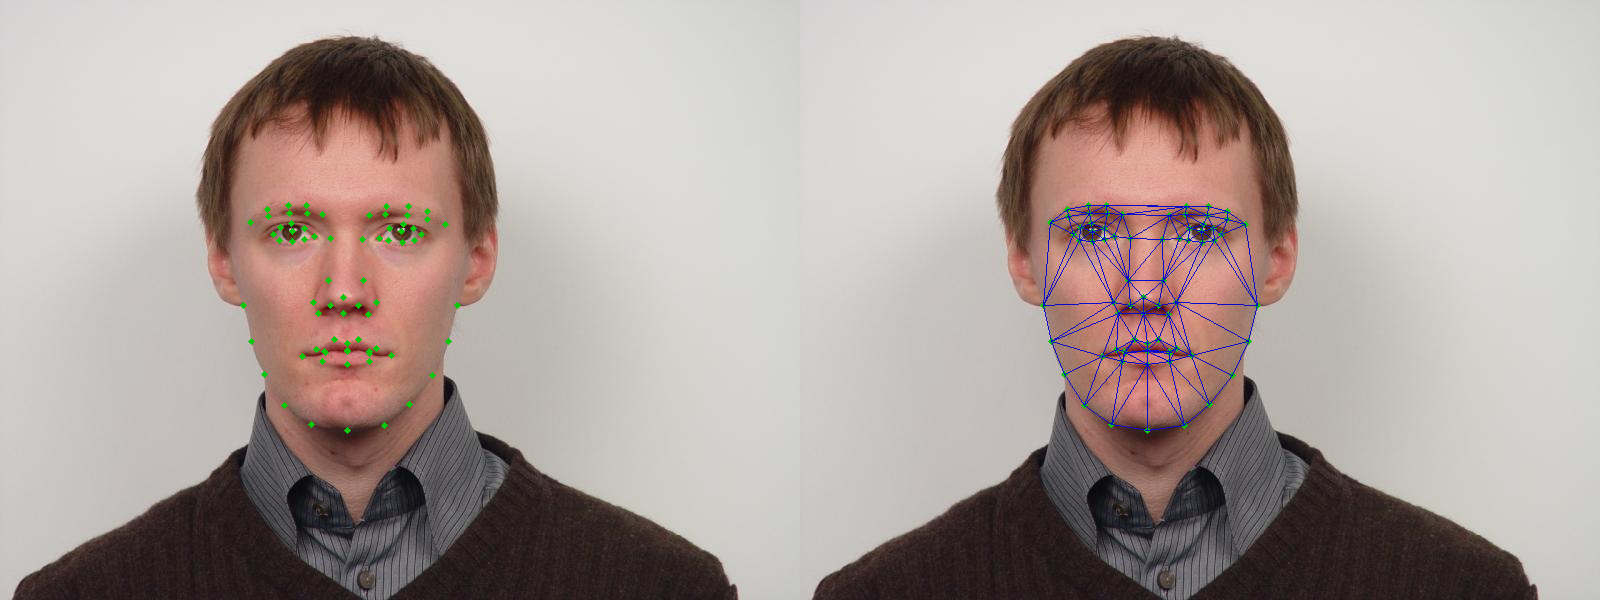

In [13]:
draw_image = cv2.imread(test_image_path)
# draw points
for point in points:
    cv2.circle(draw_image, center=point, radius=1, color=(10, 200, 10), thickness=3)

image_1 = draw_image.copy()

# draw triangle
for simp in delaunay.simplices:
    cv2.line(draw_image, pt1=points[simp[0]], pt2=points[simp[1]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=points[simp[1]], pt2=points[simp[2]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=points[simp[2]], pt2=points[simp[0]], color=(200, 10, 10), thickness=1)

image_2 = draw_image.copy()

draw_image = np.concatenate([image_1, image_2], axis=1)

Image.fromarray(draw_image[..., ::-1])

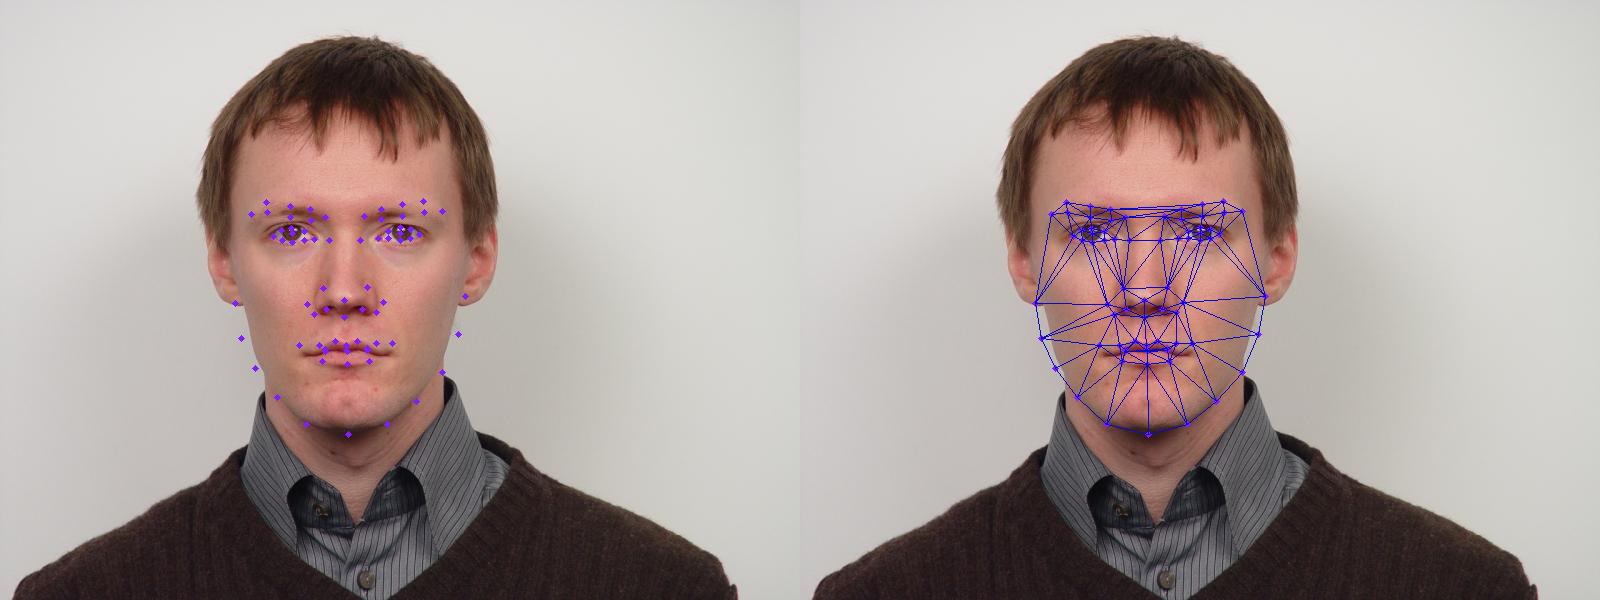

In [14]:
draw_image = cv2.imread(test_image_path)

points, _, _ = get_coordinates(test_image_path, scale_x=800, scale_y=600)
s = np.array([points])
real_s_0 = denormalise_shape(s_0.reshape(1, -1, 2), s)

mean_shape = real_s_0.reshape(-1, 2).astype(np.int_)
# draw points
for point in mean_shape:
    cv2.circle(draw_image, center=point, radius=1, color=(255, 30, 128), thickness=3)

image_1 = draw_image.copy()

# draw triangle
for simp in delaunay.simplices:
    cv2.line(draw_image, pt1=mean_shape[simp[0]], pt2=mean_shape[simp[1]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=mean_shape[simp[1]], pt2=mean_shape[simp[2]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=mean_shape[simp[2]], pt2=mean_shape[simp[0]], color=(200, 10, 10), thickness=1)

image_2 = draw_image.copy()

draw_image = np.concatenate([image_1, image_2], axis=1)

Image.fromarray(draw_image[..., ::-1])

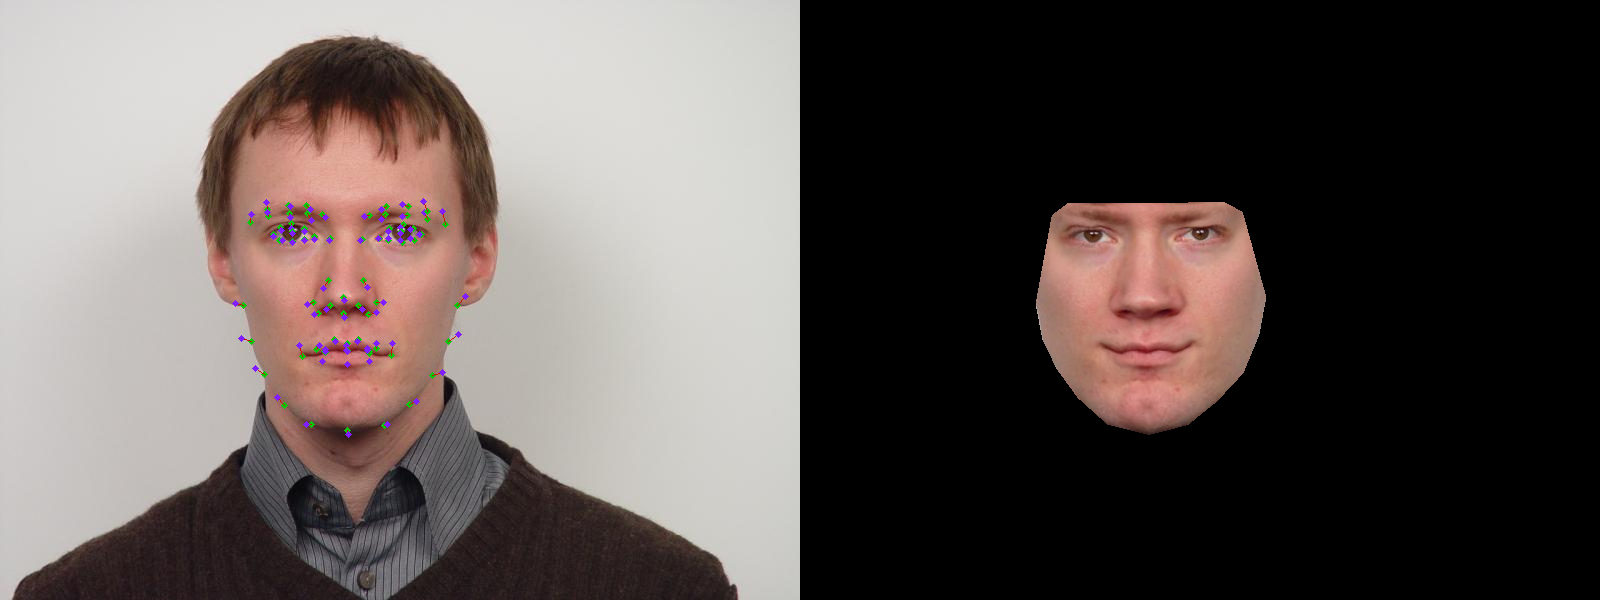

In [15]:
draw_image = cv2.imread(test_image_path)
# draw arrow
for point, mean_point in zip(points, mean_shape):
    cv2.circle(draw_image, center=point, radius=1, color=(10, 200, 10), thickness=3)
    cv2.arrowedLine(draw_image, point, mean_point, color=(0, 20, 200), thickness=1)
    cv2.circle(draw_image, center=mean_point, radius=1, color=(255, 30, 128), thickness=3)

# # draw triangle
# for simp in scipy.spatial.Delaunay(mean_shape).simplices:
#     cv2.line(draw_image, pt1=mean_shape[simp[0]], pt2=mean_shape[simp[1]], color=(255, 30, 128), thickness=1)
#     cv2.line(draw_image, pt1=mean_shape[simp[1]], pt2=mean_shape[simp[2]], color=(255, 30, 128), thickness=1)
#     cv2.line(draw_image, pt1=mean_shape[simp[2]], pt2=mean_shape[simp[0]], color=(255, 30, 128), thickness=1)
    
# # draw triangle
# for simp in scipy.spatial.Delaunay(points).simplices:
#     cv2.line(draw_image, pt1=mean_shape[simp[0]], pt2=mean_shape[simp[1]], color=(10, 200, 10), thickness=1)
#     cv2.line(draw_image, pt1=mean_shape[simp[1]], pt2=mean_shape[simp[2]], color=(10, 200, 10), thickness=1)
#     cv2.line(draw_image, pt1=mean_shape[simp[2]], pt2=mean_shape[simp[0]], color=(10, 200, 10), thickness=1)
    


image_1 = draw_image.copy()

h, w = test_image.shape[:2]
affine_trasnform = skimage.transform.PiecewiseAffineTransform()
affine_trasnform.estimate(src=source_control_points, dst=target_control_points)
image_2 = skimage.transform.warp(test_image, affine_trasnform)
image_2 = (image_2 * 255).astype('uint8')

points_array = np.array(points)
xmax, ymax = points_array.max(axis=0)
xmin, ymin = points_array.min(axis=0)
soft_margin = 50
# image_1 = image_1[ymin - soft_margin: ymax + soft_margin, xmin - soft_margin: xmax + soft_margin, :]
# image_2 = image_2[ymin - soft_margin: ymax + soft_margin, xmin - soft_margin: xmax + soft_margin, :]
draw_image = np.concatenate([image_1, image_2], axis=1)

Image.fromarray(draw_image[..., ::-1])

In [16]:
xmax, ymax = mean_shape.max(axis=0)
xmin, ymin = mean_shape.min(axis=0)
n_image = image_2[ymin: ymax, xmin: xmax, :]
n_image.shape

(233, 230, 3)

In [17]:
normalise_image = []
from tqdm import tqdm
import skimage.color

for image_file in tqdm(os.listdir(datasets_home)):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):           
        image_path = os.path.join(datasets_home, image_file)
        points, _, _ = get_coordinates(image_path, scale_x=800, scale_y=600)
        s = np.array([points])
        real_s_0 = denormalise_shape(s_0.reshape(1, -1, 2), s)
        source_control_points = real_s_0.reshape(-1, 2)
        target_control_points = s.reshape(-1, 2)
        image = cv2.imread(image_path)
        h, w = test_image.shape[:2]
        affine_trasnform = skimage.transform.PiecewiseAffineTransform()
        affine_trasnform.estimate(src=source_control_points, dst=target_control_points)
        warped_image = skimage.transform.warp(image, affine_trasnform)
        mean_shape = real_s_0.reshape(-1, 2).astype(np.int_)
        xmax, ymax = mean_shape.max(axis=0)
        xmin, ymin = mean_shape.min(axis=0)
        n_image = skimage.color.rgb2gray(warped_image[ymin: ymax, xmin: xmax, ::-1])
        normalise_image.append(n_image)

  0%|          | 0/122 [00:00<?, ?it/s]

100%|██████████| 122/122 [00:38<00:00,  3.14it/s]


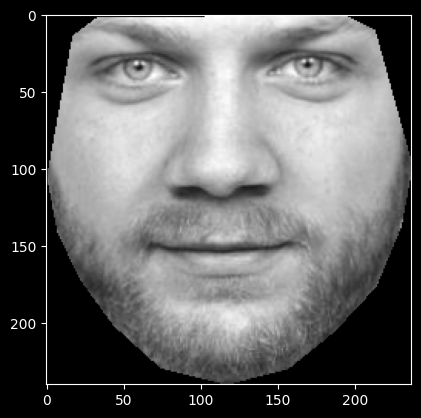

In [18]:
plt.imshow(normalise_image[0], cmap='gray')

In [32]:
resize_normalise_image = []
for image in normalise_image:
    resize_image = cv2.resize(image, (60, 60))
    resize_normalise_image.append(resize_image)

In [33]:
from appearance import appearance_mean
train_resize_images = np.array(resize_normalise_image)
image_num = len(train_resize_images)
A_0, normalise_images, beta, alpha = appearance_mean(train_resize_images)
A_0.shape, normalise_images.shape

((1, 60, 60), (120, 60, 60))

array([[-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369],
       [-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369],
       [-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369],
       ...,
       [-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369],
       [-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369],
       [-2.15924369, -2.15924369, -2.15924369, ..., -2.15924369,
        -2.15924369, -2.15924369]])

In [36]:
cov_matrix = np.cov((normalise_images.reshape(image_num, -1) - A_0.reshape(1, -1)).T)
eig_values, eig_vecs = np.linalg.eig(cov_matrix)

In [37]:
indice = eig_values.argsort()[::-1]
eig_values = eig_values[indice]
eig_vecs = eig_vecs[:, indice]

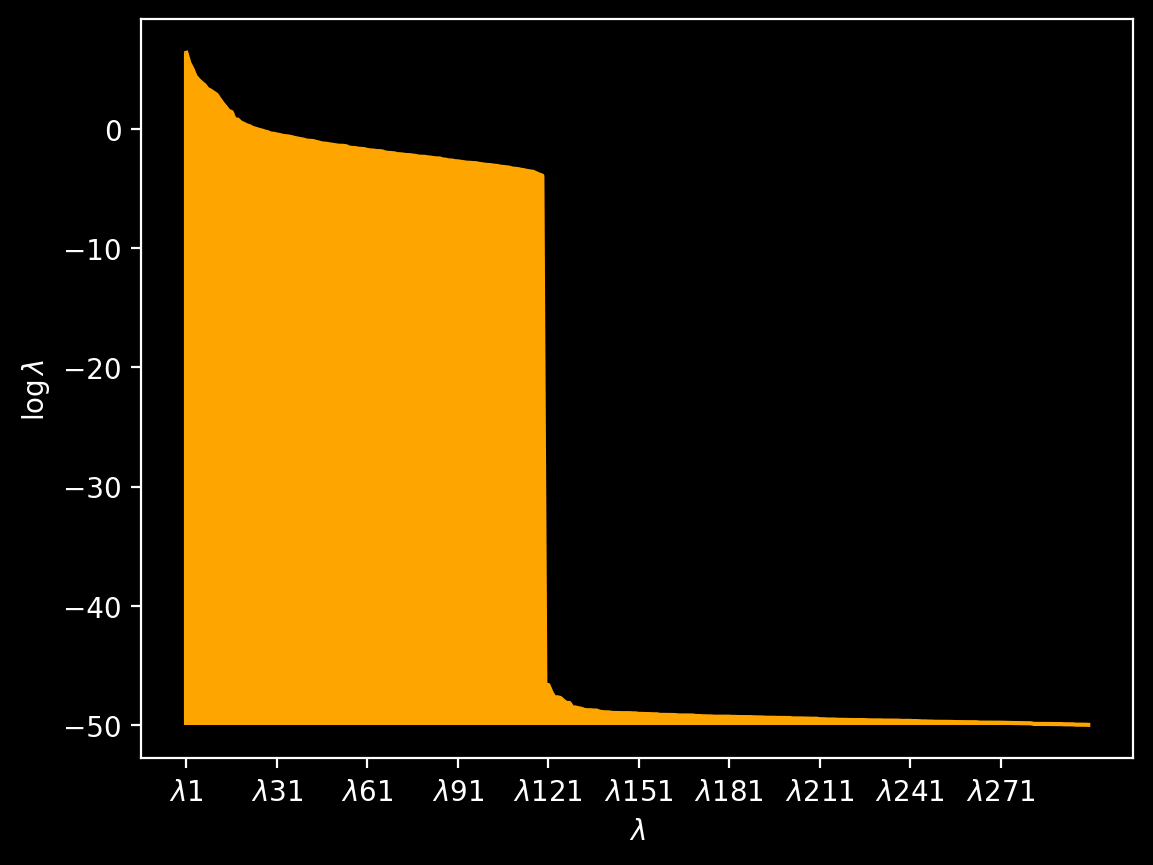

In [55]:
show_eig_values = np.log2(eig_values.real[:300])
plt.figure(dpi=200)
plt.plot(np.log2(eig_values.real[:len(show_eig_values)]), color='orange')
plt.xticks(
    np.arange(len(show_eig_values))[::(len(show_eig_values) // 10)],
    [f'$\lambda{i + 1}$' for i in range(len(show_eig_values))][::(len(show_eig_values) // 10)]
)
plt.ylabel('$\log \lambda$')
plt.xlabel('$\lambda$')
plt.vlines(np.arange(len(show_eig_values)), ymin=np.ones(len(show_eig_values)) * min(show_eig_values), ymax=show_eig_values, colors='orange')

In [58]:
eig_values.real[:100].sum() / eig_values.real.sum()

0.9942313933941298

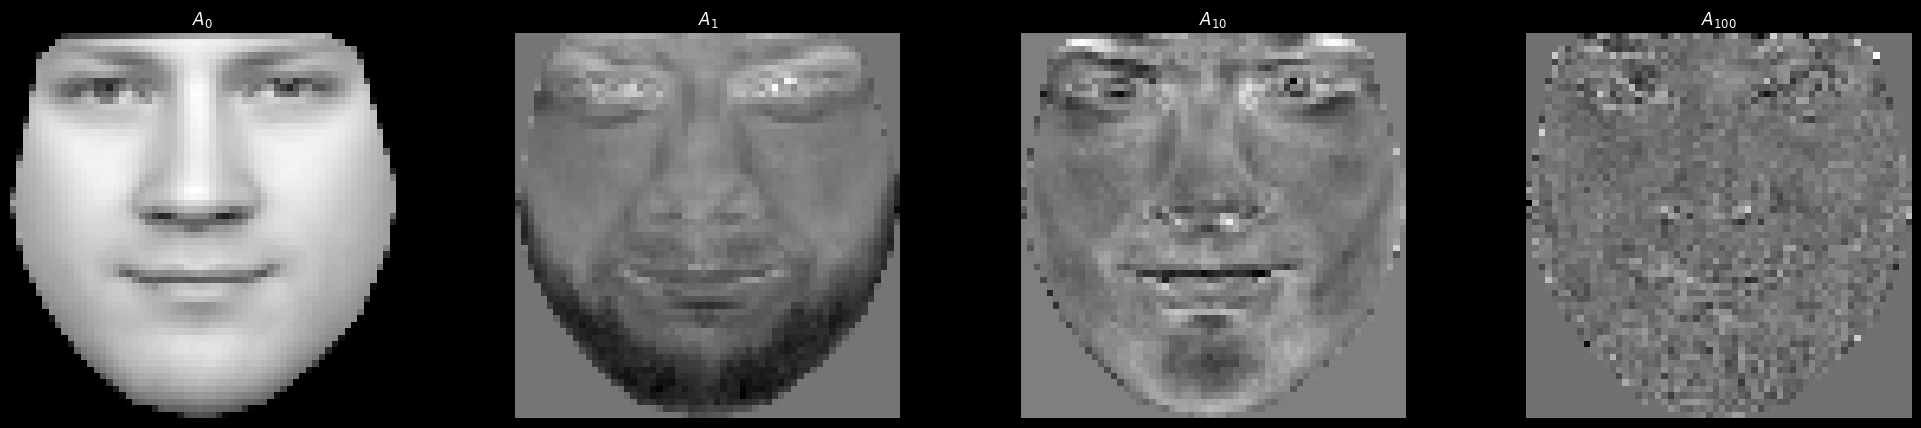

In [81]:
def visualise_appearance(appearance: np.ndarray, title: str):
    image = appearance.real.reshape(60, 60)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    
plt.figure(figsize=[25, 5])
plt.subplot(1, 4, 1)
visualise_appearance(A_0.reshape(-1), '$A_0$')
plt.subplot(1, 4, 2)
visualise_appearance(eig_vecs[:, 0], '$A_1$')
plt.subplot(1, 4, 3)
visualise_appearance(eig_vecs[:, 9], '$A_{10}$')
plt.subplot(1, 4, 4)
visualise_appearance(eig_vecs[:, 99], '$A_{100}$')

In [68]:
nn_image = normalise_images.reshape(image_num, -1) - A_0.reshape(1, -1)
nn_image.shape

(120, 3600)

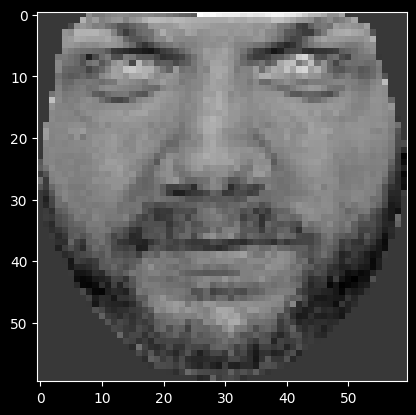